# Inhomogeneous implicit derivative

Implicit derivative definition (also `dX_dTheta` in the code):
$$
\nabla_{\boldsymbol{\Theta}} \tilde{\mathbf{X}}^*_{\boldsymbol{\Theta}} \in \mathbb{R}^{N_D\times 3N}
$$

General expression for the implicit derivative:

$$
\nabla_{\boldsymbol{\Theta}}  \mathbf{X}^*_{\boldsymbol{\Theta}}  
=
- 
\nabla_{\boldsymbol{\Theta} \mathbf{X}}^2 {U}
\big[
\nabla_{\mathbf{X} \mathbf{X}}^2 {U}
\big]^+
$$,

where $\nabla_{\mathbf{X} \mathbf{X}}^2 {U} \in \mathbb{R}^{\,3 N \times 3 N}$ is the position Hessian and $\nabla_{\boldsymbol{\Theta} \mathbf{X}}^2 {U}  \in \mathbb{R}^{N_D \times 3 N}$ is the mixed Hessian.

In [1]:
# Standard libraries
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Package imports
from lammps_implicit_der import SNAP, LammpsImplicitDer
from lammps_implicit_der.systems import BCC, BCC_BINARY, BCC_BINARY_VACANCY, BCC_VACANCY, \
                                        BCC_SIA, FromData, HCP, \
                                        BccVacancyConcentration
from lammps_implicit_der.tools import plot_tools

# No parallel MPI runs in the notebook, but keep comm for consistency
comm = None

# For parallel runs, use the following:
# from lammps_implicit_der.tools import mpi_print, initialize_mpi
# comm, rank = initialize_mpi()

## Create an atomic system. For this example, we will use one vacancy in BCC lattice with one vacancy

### Non-perturbed potential $\bar{\mathbf{\Theta}}$

Minimize with fixed cell (`minimize=True` and `fix_box_relax=False`).

By definition, the implicit derivative applies in the case of a local minimum (or maximum), therefore, the position minimization is crucial.

In [2]:
# System size affects the computational time, use ncell_x = 2 for quick test
ncell_x = 2
#ncell_x = 3

alat = 3.16316

vac0 = BCC_VACANCY(alat=alat, ncell_x=ncell_x, del_coord=[0.0, 0.0, 0.0],
                   snapcoeff_filename='W_REF.snapcoeff',
                   minimize=True, fix_box_relax=False,
                   logname='vac0.log', comm=comm)

Theta0 = vac0.pot.Theta_dict['W']['Theta'].copy()
X_coord0 = vac0.X_coord.copy()
energy0 = vac0.energy


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log vac0.log

Setting SNAP potential

                  SNAP coefficients for: W
                          quadraticflag: 0
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 4 steps
Initial fmax: 3.107e-01, final fmax: 2.754e-10
Initial fnorm: 1.522e+00, final fnorm: 1.349e-09
Number of atoms: 15, largest force value: 2.754e-10, force norm: 1.349e-09


## Compute the implicit derivative (`self.implicit_derivative()` method)

* `implicit_derivative()` - implicit derivative wrapper, `method` keyword selects the derivative method, options are:

    * `inverse` - Moore-Penrose inverse of the Hessian matrix, `np.linalg.pinv()`
    * `dense` -  pseudoinverse from the system of linear equations, `np.linalg.solve(hessian, mixed_hessian)`
    * `sparse` - sparse linear method, solve for each potential parameter $\Theta_l$ separately
    * `energy` - constraint energy minimization in LAMMPS with additional force and energy terms that correspond to a given parameter $\Theta_l$

### Compute the implicit derivative with the dense pseudoinverse Hessian method (`method=dense`)

In [3]:
dX_dTheta_dense = vac0.implicit_derivative(method='dense')

Computing the Hessian...


Hessian (full): 100%|██████████| 45/45 [00:00<00:00, 56.77it/s]

Computing dX_dTheta with linalg.solve, Hessian shape: (45, 45)


## Predict the change in positions with the implicit derivative

Perturbation potential is:

$$
\mathbf{\Theta}(\lambda,m) = \bar{\mathbf{\Theta}} + \lambda( \mathbf{\Theta}_m -\bar{\mathbf{\Theta}}),
$$

where $m$ is potential sample from `Theta_ens` ensemble and $\lambda$ is perturbation strength.

In [4]:
# Read the potential ensemble
with open('Theta_ens.pkl', 'rb') as f:
    Theta_ens = pickle.load(f)

# Select an arbitrary sample from the ensemble and perturb the potential with delta=40.0
delta = 40.0
sample = 5
Theta_perturb = Theta_ens['Theta_mean'] + delta * (Theta_ens['Theta_ens_list'][sample] - Theta_ens['Theta_mean'])

# Potential perturbation
dTheta = Theta_perturb - Theta0


dX_pred_dense = dTheta @ dX_dTheta_dense

### To compute the true value of position change, create a perturbed LAMMPS system with the $\mathbf{\Theta}(\lambda,m)$ potential:

In [10]:
# Save the perturbed Theta to a file
pot = SNAP.from_files(snapcoeff_filename='W_REF.snapcoeff', snapparam_filename='W_REF.snapparam', comm=comm)
pot.Theta_dict['W']['Theta'] = Theta_perturb.copy()
pot.to_files(snapcoeff_filename='W_perturb_new.snapcoeff', snapparam_filename='W_perturb_new.snapparam',
             overwrite=True, verbose=True)

# This step is required for the true positions change from the LAMMPS minimization
# Since the potential is written to the current folder, we specify  data_path='.'
vac_perturb = BCC_VACANCY(alat=alat, ncell_x=ncell_x, del_coord=[0.0, 0.0, 0.0],
                          data_path='.',
                          snapcoeff_filename='W_perturb_new.snapcoeff',
                          minimize=True, fix_box_relax=False,
                          logname='vac0.log', verbose=False, comm=comm)

# True minimized positions
X_true = vac_perturb.X_coord.copy()
# True difference in positions with minimum image convention applied
dX_true = vac0.minimum_image(X_true - X_coord0)

Overwriting ./W_perturb_new.snapcoeff
Overwriting ./W_perturb_new.snapparam
Saved SNAP coefficients to ./W_perturb_new.snapcoeff
Saved SNAP parameters to ./W_perturb_new.snapparam


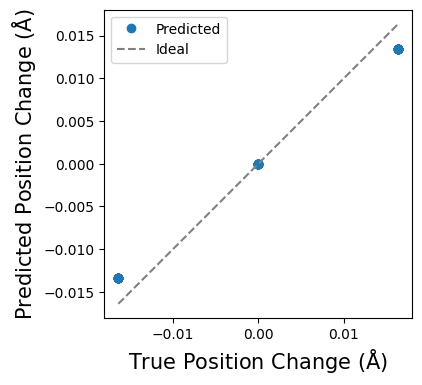

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set_aspect('equal')
ax.plot(dX_true, dX_pred_dense, ls='', marker='o', label='Predicted')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='--', color='gray', label='Ideal')
fsize = 15
ax.set_xlabel(r'True Position Change ($\mathrm{\AA}$)', fontsize=fsize)
ax.set_ylabel(r'Predicted Position Change ($\mathrm{\AA}$)', fontsize=fsize)
ax.legend()
plt.show()

## Compare the implicit derivative evaluation methods

For small systems, the `dense` method is the most reliable and fast. However, with systems reaching more the 100 atoms, the `energy` method becomes the most memory and time-efficient.

While for the `dense` method, there is no adjustable parameters, the `sparse` and `energy` methods' efficiency and accuracy might depend on several parameters. Below are optimal parameters for the tested systems, however, they should be tested and adjusted for a new system.

For `sparse` and `energy` methods, we recommend setting `adaptive_alpha=True` (which is its default value). Then, the finite difference parameter $\alpha(l)$ is computed for each potential parameter $\mathbf{\Theta}_l$ separately:

$$
\alpha(l) = \frac{\alpha_0}{\max{\big(\big| \big[ \nabla^2_{\mathbf{\Theta}\tilde{\mathbf{X}}} U \big]_l \big|\big)} }
$$

### Parameters for `sparse` method:

* `alpha0`: the $\alpha_0$ scaling factor, recommended values `[1e-2; 1e-5]`, default `1e-2`  
* `atol`: absolute tolerance for implicit derivative calculation for the `lgmres` solver (default `1e-5`)
* `maxiter`: maximal number of iterations of the solver (default `500`)

### Parameters for `energy` method:

* `min_style`: LAMMPS constraint energy minimization algorithm. Options: fire, cg, sd, htfn.
* `alpha0`: the $\alpha_0$ scaling factor, numerically, it has a different meaning then for the `sparse` method. Therefore, the values for each method should be adjusted separately. `alpha0` parameter also depends on `min_style`.
* `ftol`: force tolerance for constrained LAMMPS minimization (default=1e-8). Affects the accuracy and computational time.  
* `maxiter`: Number of iterations of constrained LAMMPS minimization

In [7]:
dX_dTheta_sparse = vac0.implicit_derivative(method='sparse',
                                            adaptive_alpha=True,
                                            alpha0=1e-4,
                                            maxiter=500,
                                            atol=1e-4)

dX_dTheta_energy_fire = vac0.implicit_derivative(method='energy',
                                                 adaptive_alpha=True,
                                                 alpha0=1e-4,
                                                 min_style='fire',
                                                 ftol=1e-8,
                                                 maxiter=500)

dX_dTheta_energy_cg = vac0.implicit_derivative(method='energy',
                                               adaptive_alpha=True,
                                               alpha0=1e-6,
                                               min_style='cg',
                                               ftol=1e-8,
                                               maxiter=500)

dX_pred_sparse = dTheta @ dX_dTheta_sparse
dX_pred_energy_fire = dTheta @ dX_dTheta_energy_fire
dX_pred_energy_cg = dTheta @ dX_dTheta_energy_cg

Impl. Der. Energy CG: 100%|██████████| 55/55 [00:01<00:00, 41.17it/s]


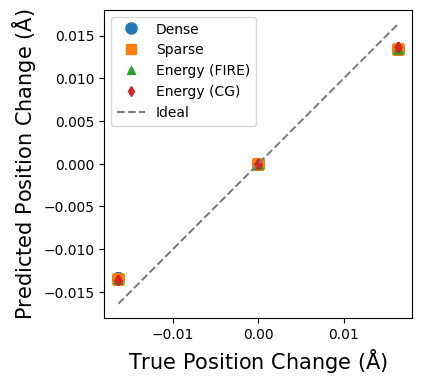

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set_aspect('equal')
ax.plot(dX_true, dX_pred_dense, ls='', marker='o', ms=8, label='Dense')
ax.plot(dX_true, dX_pred_sparse, ls='', marker='s', ms=7, label='Sparse')
ax.plot(dX_true, dX_pred_energy_fire, ls='', marker='^', ms=6, label='Energy (FIRE)')
ax.plot(dX_true, dX_pred_energy_cg, ls='', marker='d', ms=5, label='Energy (CG)')

ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='--', color='gray', label='Ideal')
fsize = 15
ax.set_xlabel(r'True Position Change ($\mathrm{\AA}$)', fontsize=fsize)
ax.set_ylabel(r'Predicted Position Change ($\mathrm{\AA}$)', fontsize=fsize)
ax.legend()

plt.show()

### Runtime of methods:

In [9]:
print(vac0.timings.timings['implicit_derivative_dense'])
print(vac0.timings.timings['implicit_derivative_sparse'])
# Energy runtime consists of cg (fast) and fire (slower) minimization
print(vac0.timings.timings['implicit_derivative_energy'])

         ▷-----implicit_derivative_dense  0.82744      1         
         ▷----implicit_derivative_sparse  2.23462      1         
         ▷----implicit_derivative_energy  26.92588     2         
